<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data preprocessing</center>

# Challenge S7: Clasificación de sentimientos en tweets

## Objetivos:

El objetivo de este challenge es enfrentarse a un problema de clasificación de texto real: tweets descargados sobre las elecciones de EEUU en 2016, centrándonos en el preprocesamiento, que en este caso es crucial en un problema en el que el protagonista es el texto.

## Inicialización del entorno:

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
from nltk.tokenize import sent_tokenize, word_tokenize

random.seed(1234)
pd.set_option('display.max_colwidth', 175) # incrementamos anchura de output

In [2]:
df_train = pd.read_csv('./data/gop_tweets_train_psn.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8414 entries, 0 to 8413
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  8414 non-null   object
 1   text       8414 non-null   object
dtypes: object(2)
memory usage: 131.6+ KB


In [3]:
df_train['token_length'] = [len(x.split(" ")) for x in df_train.text]

In [4]:
# Remove tweets whose length is <= 2
too_short_train = df_train['token_length'] <= 2
df_train['text'][too_short_train]
df_train['text'] = df_train['text'][~too_short_train]
df_train = df_train.dropna()

In [5]:
df_test = pd.read_csv('./data/gop_tweets_test_psn.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  2153 non-null   object
 1   text       2153 non-null   object
dtypes: object(2)
memory usage: 33.8+ KB


In [6]:
df_test['token_length'] = [len(x.split(" ")) for x in df_test.text]

In [7]:
too_short_test = df_test['token_length'] <= 2
df_test['text'] = df_test['text'][~too_short_test]
df_test = df_test.dropna()

Damos un vistazo a los textos que aparecen en el dataset.

In [8]:
df_train.head()

,sentiment,text,token_length
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate,15
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…,21
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.,15
3,Positive,RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on …,25
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co…,17


In [9]:
df_test.head()

,sentiment,text,token_length
0,Positive,"RT @GregAbbott_TX: @TedCruz: ""On my first day I will rescind every illegal executive action taken by Barack Obama."" #GOPDebate @FoxNews",20
1,Neutral,Going on #MSNBC Live with @ThomasARoberts around 2 PM ET. #GOPDebate,12
2,Positive,RT @WayneDupreeShow: Just woke up to tweet this out #GOPDebate \r\n\r\nBest line of the night via @GovMikeHuckabee http://t.co/6OV5hxHIcV,18
3,Negative,reason comment is funny 'in case you're ignorant' is the #gop #tcot are the reason the government isn't working for the people #gopdebate,23
4,Positive,"RT @ChuckNellis: Cruz has class &amp; truth, that gets my vote! #GOPDebate",12


In [10]:
# Prueba de resampleo simple.
from sklearn.utils import resample
#
#
majority_tr = df_train[df_train.sentiment=="Negative"]
minority_tr = df_train[df_train.sentiment=="Neutral"]
minority_1_tr = df_train[df_train.sentiment=="Positive"]
##
minority_upsampled_tr = resample(minority_tr,replace=True,n_samples=len(majority_tr),random_state=123)
minority_1_upsampled_tr = resample(minority_1_tr,replace=True,n_samples=len(majority_tr),random_state=123)
##
upsampled_trained_tr = pd.concat([minority_upsampled_tr,minority_1_upsampled_tr, majority_tr])
#upsampled_trained_tr['sentiment'].value_counts()

## ¿Qué número de tweets tenemos en cada dataset? ¿Cuántos de cada clase?

In [11]:
print(df_train.sentiment.value_counts())
print(df_test.sentiment.value_counts())

Negative    4871
Neutral     2160
Positive    1379
Name: sentiment, dtype: int64
Negative    1256
Neutral      567
Positive     327
Name: sentiment, dtype: int64


In [12]:
import re
def  clean_text(df, text):
    df[text] = df[text].str.lower()
    # El resultado empeora cuando ejecuto esta regex
    #df[text] = df[text].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem,flags=re.I))  
    return df
#
test_clean = clean_text(df_test, "text")
train_clean = clean_text(df_train, "text")
#


## ¿Qué dificultades crees que presenta la diferencia entre la cantidad de clases?

Sera mas probable clasificar un sentimiento negativo que uno neutral o positivo cuando no este claro.

## Clasificador de tweets

Vamos a construir nuestro propio clasificador sobre los tweets que hemos cargado. Los pasos que seguiremos serán:

* Preprocesar ambos conjuntos de tweets por separado.
* Entrenar clasificador con tweets de entrenamiento.
* Evaluar con tweets de test.

Primero, haremos una prueba para observar el rendimiento de nuestro clasificador sin ningún tipo de preprocesamiento.

In [13]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

Seguimos creando el clasificador y entrenando con el conjunto de entrenamiento de los tweets.

In [14]:
# creamos nuestro pipeline con vectorizador (bag of words) y clasificador
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', LinearSVC(max_iter=1200))])

# entrenamos el clasificador
text_clf.fit(df_train['text'], df_train['sentiment'])

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1200,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.000

Realizamos las predicciones con el conjunto de test y obtenemos la métrica de evaluación.

In [15]:
predicted = text_clf.predict(df_test['text'])
np.mean(predicted == df_test['sentiment'])

0.5990697674418605

Parece que hemos obtenido un resultado un poco peor... Ahora es cuando entra en juego el preprocesamiento del texto.

Ahora vamos a preprocesar el texto y construir un clasificador. Para ello, se ha creado esta función que nos automatiza el preprocesamiento. Deberás añadir el código que creas necesario y ejecutar la función para obtener el texto preprocesado. 

**Puedes definir todas las funciones de preprocesado que creas necesario, pero ten en cuenta varios detalles:**
* La funcion `preprocesar_texto` es llamada desde un `apply`. Esto significa que la función recibe un tweet y devuelve un tweet preprocesado con cada llamada. 
* Si el preprocesado es muy agresivo, un tweet puede quedarse fácilmente vacío, en esos casos el clasificador no podrá trabajar con él y escupirá la clase mayoritaria para ese tweet.
* Algunas técnicas no tienen sentido si se aplican después de otras dentro del pipeline. Por ejemplo, no tiene sentido aplicar POS después de realizar Stemming.
* Count Vectorizer necesita DOCUMENTOS y al trabajar con texto muchas veces es más sencillo hacer uso de TOKENS. Esto significa que tendremos que pasar cada tweet preprocesado en una cadena de texto. La función `" ".join(palabras)` que vimos en el worksheet es tu aliada.
* Si tu preprocesamiento va a ser intensivo, quizás es buena idea crear varias funciones que sean llamadas desde `preprocesar_texto`.

In [16]:
def preprocesar_texto(texto):
    """ Función para preprocesamiento de texto.
    Args:
        texto: cadena de texto a preprocesar.
    Returns:
        mismo texto preprocesado.
    """
    texto_filtrado = ""
    # AQUÍ TU CÓDIGO
    punt = remove_p_marks(texto)
    stp = remove_stopwords(punt)
    #stemm_tokens = stemm(stp)
    lemm_tokens = lemm(stp)
    #stemm_tokens = stemm(lemm_tokens)
    texto_filtrado = ' '.join(lemm_tokens)
    return texto_filtrado

In [17]:
def remove_p_marks(txt):
    """
        Function to remove punctuation marks
    Args:
        txt: Text to proccess
    Return:
         Text without punctuation marks
    """
    clean_tweet = ""
    marks = [',', '.\n','.',';', ':','"' ,'?', '¿', '!', '¡','...','..','\n']
    for i in txt:
        if i.lower() in marks:
            pass
        else:
            clean_tweet += i
    return clean_tweet

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

def remove_stopwords(txt):
    """Function to Tokenize words and remove stopwords|
    Args: 
        txt : Text to proccess
    Return:
        Text tokenized with word length >= than 3 and without stopwords.
    """
    custom_filter = ['-','/','*','”','…','%','’','&','@','#']
    tweets_filtered = []
    #words = word_tokenize(txt)
    words = TweetTokenizer().tokenize(txt)
    stp = stopwords.words('english')
    for i in words:
        if i.lower() in stp:
            pass
        if len(i) <= 2:
            pass
        elif i.lower() in custom_filter:
            pass
        else:
            tweets_filtered.append(i)
    return tweets_filtered    

In [19]:
from nltk.stem import SnowballStemmer
def stemm(tokens):
    stemmer = SnowballStemmer('english')
    tokens_stemmed = [stemmer.stem(x) for x in tokens]
    return set(tokens_stemmed)

In [20]:
def get_wordnet_pos(word):
    
    """Map POS tag to first character lemmatize() accepts"""

    tag = nltk.pos_tag([word])[0][1][0].upper()
    #print(tag)
    tag_dict = {"J": wordnet.ADJ,
                  "N": wordnet.NOUN,
                  "V": wordnet.VERB,
                  "R": wordnet.ADV}
    #print(wordnet.ADJ)
    return tag_dict.get(tag, wordnet.ADJ)

In [21]:
from nltk import pos_tag
from nltk.corpus import wordnet
def lemm(tokens):
    lemmatizer = nltk.WordNetLemmatizer()
    processed_tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    return processed_tokens

Aplicamos el preprocesamiento a los dos conjuntos de tweets y lo guardamos en la columna `prep`.

In [22]:
df_train['prep'] = df_train['text'].apply(preprocesar_texto)
df_test['prep'] = df_test['text'].apply(preprocesar_texto)

In [23]:
df_train.head(20)

,sentiment,text,token_length,prep
0,Neutral,rt @nancyleegrahn: how did everyone feel about the climate change question last night? exactly. #gopdebate,15,@nancyleegrahn how do everyone feel about the climate change question last night exactly #gopdebate
1,Positive,rt @scottwalker: didn't catch the full #gopdebate last night. here are some of scott's best lines in 90 seconds. #walker16 http://t.co/zsff…,21,@scottwalker didn't catch the full #gopdebate last night here be some scott's best line second #walker16 http tco zsff
2,Neutral,rt @tjmshow: no mention of tamir rice and the #gopdebate was held in cleveland? wow.,15,@tjmshow mention tamir rice and the #gopdebate be held cleveland wow
3,Positive,rt @robgeorge: that carly fiorina is trending -- hours after her debate -- above any of the men in just-completed #gopdebate says she's on …,25,@robgeorge that carly fiorina trend hour after her debate above any the men just-completed #gopdebate say she's
4,Positive,rt @danscavino: #gopdebate w/ @realdonaldtrump delivered the highest ratings in the history of presidential debates. #trump2016 http://t.co…,17,@danscavino #gopdebate @realdonaldtrump deliver the high rating the history presidential debate #trump2016 http tco
5,Negative,rt @warriorwoman91: i liked her and was happy when i heard she was going to be the moderator. not anymore. #gopdebate @megynkelly https://…,24,@warriorwoman91 like her and be happy when heard she be go the moderator not anymore #gopdebate @megynkelly http
6,Negative,"deer in the headlights rt @lizzwinstead: ben carson, may be the only brain surgeon who has performed a lobotomy on himself. #gopdebate",22,deer the headlight @lizzwinstead ben carson may the only brain surgeon who have perform lobotomy himself #gopdebate
7,Negative,rt @nancyosborne180: last night's debate proved it! #gopdebate #batsask @badassteachersa #tbats https://t.co/g2ggjy1bjd,13,@nancyosborne180 last night's debate prove #gopdebate #batsask @badassteachersa #tbats http tco g2ggjy1bjd
8,Negative,@jgreendc @realdonaldtrump in all fairness #billclinton owns that phrase.#gopdebate,9,@jgreendc @realdonaldtrump all fairness #billclinton own that phrase #gopdebate
9,Negative,me reading my family's comments about how great the #gopdebate was http://t.co/giagjpygxz,12,reading family's comment about how great the #gopdebate be http tco giagjpygxz


Antes de reentrenar nuestro clasificador, siempre es recomendable dar un vistazo al resultado del texto. Podemos observar frecuencia de palabras o simplemente generar un WordCloud.

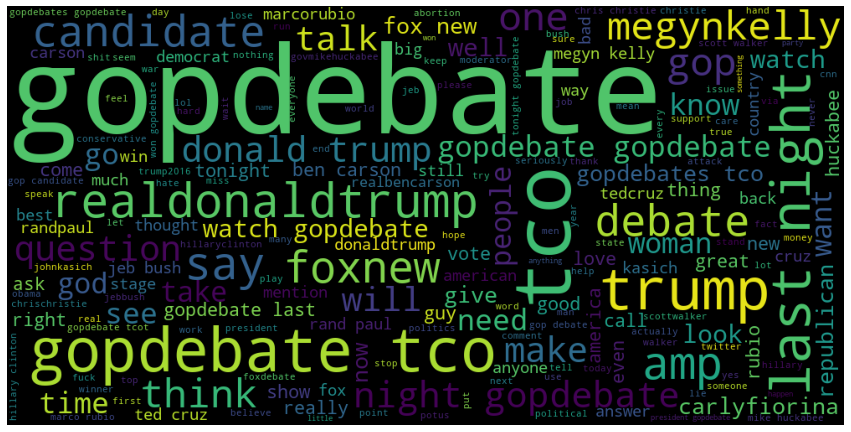

In [24]:
# AQUÍ TU CÓDIGO
text = df_train['prep']
texto = text.tolist()
words = ' '.join(texto)
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 500, relative_scaling = 0.5).generate(words)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


Ahora sí, vamos a reentrenar el clasificador y evaluar de nuevo. Puedes hacer uso del mismo pipeline anterior o simplemente crear uno nuevo con más etapas.

In [25]:
# Nuevo pipeline si es que es necesario. Por defecto usamos el anterior.
#new_clf = text_clf
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.pipeline import make_pipeline
#from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

lsvc = LinearSVC()
sgdc = SGDClassifier()

text_clf2 = Pipeline([('vect', CountVectorizer(ngram_range=(1, 3),tokenizer = TweetTokenizer().tokenize)),
                     ('tfidf', TfidfTransformer(use_idf = True, smooth_idf=True)),
                     ('clf', lsvc)])
text_clf2.fit(df_train['text'], df_train['sentiment'])

#from sklearn.feature_extraction.text import CountVectorizer
#count_vect = CountVectorizer(tokenizer = TweetTokenizer().tokenize)
#X_train_counts = count_vect.fit_transform(df_train['text'])
#print(count_vect.get_feature_names())

Using TensorFlow backend.


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<bound method TweetTo...eetTokenizer object at 0x139b99b90>>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,


In [26]:
# Predicción haciendo uso del pipeline correspondiente. ¡Recuerda cambiarlo si has creado uno nuevo!
predicted = text_clf2.predict(df_test['prep'])
np.mean(predicted == df_test['sentiment'])


0.6632558139534884

* ¿Qué opinas de los resultados obtenidos?
* ¿Por qué crees que ha sucedido esto?

- #### El maximo valor que he podido obtener ha sido 0.66 , despues de iterar varias veces.

- #### Las combinaciones/pruebas que he hecho han sido:
    
    - 1)  Usar limpieza de signos/stop words y solo lematizacion, clasificador LinearSVC y Tf-idf con y sin ngram_range
    - 2)  Usar limpieza de signos/stop words y solo stemmizacion,clasificador LinearSVC y Tf-idf con y sin ngram_range
    - 3)  Usar limpieza de signos/stop words y usar primero lematizacion y luego stemmizacion,clasificador LinearSVC y Tf-idf con y sin ngram_range
    - 4)  Filtrando urls/arrobas/numeros etccc , limpiando signos y stop words y repetir 1) 2) y 3), curiosamente ,
        con el texto mas "limpio", obtenia un valor inferior a 0.65 , en torno a ~0.64, con clasificador LinearSVC y Tf-idf con y sin ngram_range
    - 5)  Las otras combinaciones con otros clasificadores como SGDClassifier y LogisticRegression y tocando alguna parametrizacion.
    - 6) Por otro lado he tratado de hacer resampleo de las clases minoritarias en el dataset de training , pero el resultado ha sido peor (0.63).
         Bien es cierto, que el resampleo ha sido demasiado simple.
    - 7) El valor maximo lo he conseguido con el siguiente setup: clasificador LinearSVC CountVectorizer con el tweet tokenizer Tf-idf y ngram_range (1,3).
         Con SGDClassifier obtengo un valor ligeramente superior en general que con LinearSVC, pero este valor es distinto cada vez ,dado que usa un punto aleatorio cada vez que lo ejecuta en lugar del dataset de training entero.

- #### El valor bajo puede tener que ver con el desbalanceo de las clases entre otras cosas. Tambien, probablemete el uso de jergas, contracciones del ingles , etc ... He mirado de pasada el tema de los chunks y me da la sensacion que en el tipo de lenguaje de twitter esto no seria de gran ayuda


¿Podrías explicarme con tus palabras en qué consiste Tf-Idf? ¿Cual es la idea intuitiva de aplicar esta transformación a la matriz?

- #### Es una manera de convertir los datos de texto en valores numericos
 -  tf significa frecuencia de termino e idf frecuencia inversa de documento. Con tf calculamos la frecuencia relativa de un termino respecto al documento y con idf calculamos la frecuencia con que un termino aparece en todos los documentos. En el caso de tf se penaliza la poca aparicion del termino, y con idf se penaliza la excesiva aparicion de un termino en todos los documentos, entiendo que por no aportar excesiva informacion.